In [20]:
# Libraries
# ======================================================================================
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  HistGradientBoostingRegressor
import skforecast
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import shap
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import importlib
import seaborn as sns
warnings.filterwarnings('once')

print(f"Version skforecasy: {skforecast.__version__}")
print(f"Version scikit-learn: {sklearn.__version__}")

Version skforecasy: 0.12.1
Version scikit-learn: 1.3.0


# Prepare Data

In [37]:
# read in data
survey_file = '/Users/htr365/no_icloud/quantified_self_all/data/survey_data/pre_processed_survey_features.csv'
df = pd.read_csv(survey_file,index_col=0)

In [38]:
# set person
person = 'Johanna'

In [39]:
# filter a person
df = df[df['person']==person]
df.index = df['date']

In [40]:
# exclude two days at the beginning (due to long break inbetween) if its Amanda
if (person == 'Amanda'):
    df = df[df['date']>='2024-07-08']

In [41]:
# set index and frequency
df.index =  pd.to_datetime(df['date'])
df = df.sort_index()
# get complete list of dates
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
# Reindex the DataFrame to include all dates in the range
df = df.reindex(all_dates)
df = df.fillna(method='ffill')  # Forward fill missing values
# set frequency to daily
df.index.freq = 'D'

In [42]:
# define variables of interest and get human prediction
human_prediction = df[['fatigue_expected','muscles_sore_expected','muscles_tired_expected']]
pred_variables = ['cis_subjective_fatigue', 'hooper_muscles_sore','extra_muscles_tired']
variables_of_interest = ['cis_subjective_fatigue','cis_concentration','cis_motivation','cis_physical_activity',
                         'hooper_fatigue_level','hooper_stress_level', 'hooper_muscles_sore','hooper_sleep_quality',
                         'extra_muscles_tired','step_count','sleep_time','alcohol']
vars = [ 'cis_1', 'cis_2', 'cis_3', 'cis_4', 'cis_5', 'cis_6',
       'cis_7', 'cis_8', 'cis_9', 'cis_10', 'cis_11', 'cis_12', 'cis_13',
       'cis_14', 'cis_15', 'cis_16', 'cis_17', 'cis_18', 'cis_19', 'cis_20',
       'hooper_muscles_sore', 'extra_muscles_tired', 'hooper_sleep_quality',
       'hooper_fatigue_level', 'hooper_stress_level', 
       'coffee_count', 'step_count', 'alcohol',
       'fatigue_expected', 'muscles_sore_expected', 'muscles_tired_expected',
       'cis_subjective_fatigue', 'cis_concentration', 'cis_motivation',
       'cis_physical_activity', 'sleep_time','walking', 'cycling', 'ball_sports',
       'weight_lifting', 'running', 'yoga', 'HITT','manual_labour']

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 0.03650218, -0.19714197, -0.18793741, -0.27205952, -0.1322844 ,
         0.02613625, -0.07647766, -0.0500705 ,  0.17220533,  0.28000752,
         1.        ,  0.28000752,  0.17220533, -0.0500705 , -0.07647766,
         0.02613625, -0.1322844 , -0.27205952, -0.18793741, -0.19714197,
         0.03650218]),
 <matplotlib.lines.Line2D at 0x7fbf60af3b80>)

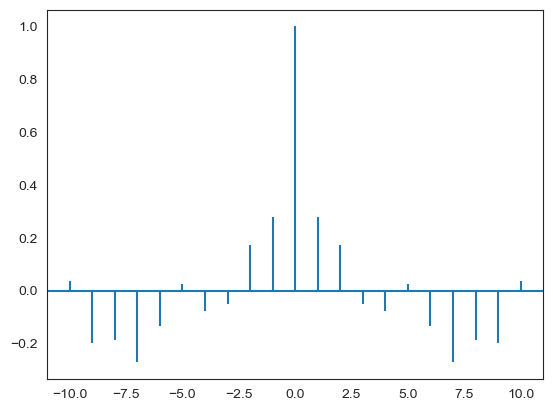

In [43]:
plt.acorr(df['cis_subjective_fatigue']-df['cis_subjective_fatigue'].mean(), maxlags = 10) 


(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([-0.07633986,  0.0680582 , -0.11113635, -0.24005157, -0.13325557,
         0.08634661,  0.22064583, -0.19662349,  0.03178832, -0.10335809,
         1.        , -0.10335809,  0.03178832, -0.19662349,  0.22064583,
         0.08634661, -0.13325557, -0.24005157, -0.11113635,  0.0680582 ,
        -0.07633986]),
 <matplotlib.lines.Line2D at 0x7fbf52724ca0>)

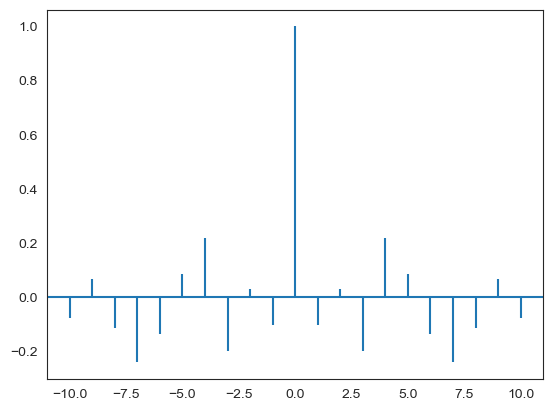

In [44]:
plt.acorr(df['extra_muscles_tired']-df['extra_muscles_tired'].mean(), maxlags = 10) 


(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([-0.25876424, -0.01248904,  0.17166959, -0.08972393, -0.17090272,
        -0.02738826,  0.00953111, -0.05554338, -0.01402279,  0.23992112,
         1.        ,  0.23992112, -0.01402279, -0.05554338,  0.00953111,
        -0.02738826, -0.17090272, -0.08972393,  0.17166959, -0.01248904,
        -0.25876424]),
 <matplotlib.lines.Line2D at 0x7fbf60bb8fd0>)

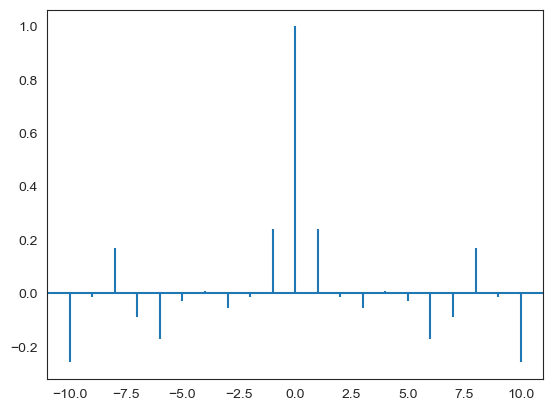

In [45]:
plt.acorr(df['hooper_muscles_sore']-df['hooper_muscles_sore'].mean(), maxlags = 10) 

<Figure size 640x480 with 0 Axes>

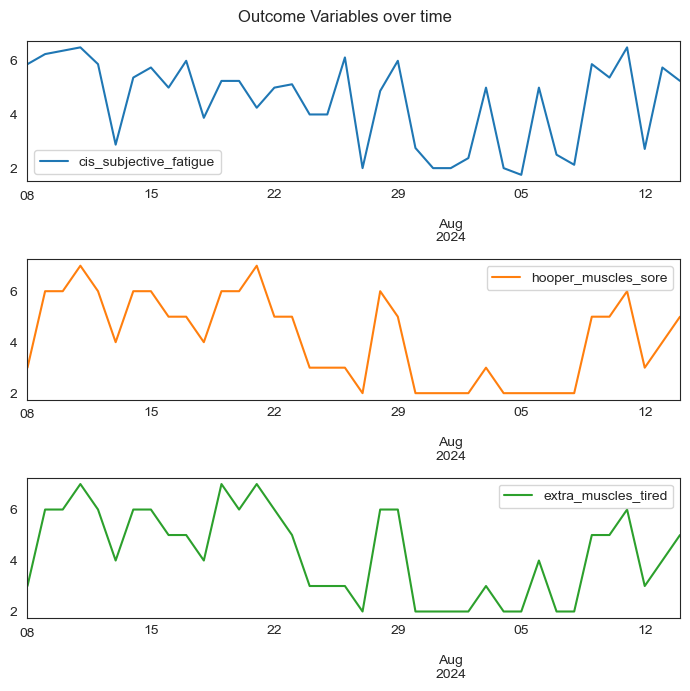

In [8]:
# Plot time series
# ======================================================================================
sns.set_style("white")
sns.despine()
fig, axs = plt.subplots(len(pred_variables), 1, figsize=(7, 7), sharex=False)
df[pred_variables].plot(
    legend   = True,
    subplots = True, 
    title    = 'Outcome Variables over time',
    ax       = axs, 
)
fig.tight_layout()
plt.show()

In [46]:
# define train and test data
data= df
if person=='Johanna':
    end_train = round(len(data.index)*0.78)
if person=='Amanda':
    end_train = round(len(data.index)*0.8)
end_train = data.index[end_train]

In [47]:
data_train = data.loc[:end_train,pred_variables].copy()
#data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_train:,pred_variables].copy()
print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
#print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2024-06-24 00:00:00 --- 2024-07-21 00:00:00  (n=28)
Test dates       : 2024-07-21 00:00:00 --- 2024-07-28 00:00:00  (n=8)


In [ ]:
end_train

In [48]:
data_all = df[variables_of_interest]

In [49]:
# Function to give 0 weights to imputed data
# see: https://cienciadedatos.net/documentos/py46-forecasting-time-series-missing-values
def custom_weights(index):
    """
    Return 0 if index is in any gap.
    """
    if (person == 'Amanda'):
        gaps = [['2024-07-25','2024-08-01']]
    else: gaps =[[]]
    weights = np.where(index.isin(gaps), 0, 1)

    return weights

# Evaluate Human Prediction

In [50]:
# create lead variable
human_prediction['muscles_sore_prediction']= human_prediction['muscles_sore_expected'].shift(1)
human_prediction['muscles_tired_prediction']= human_prediction['muscles_tired_expected'].shift(1)
human_prediction['fatigue_prediction']= human_prediction['fatigue_expected'].shift(1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
# merge prediction and true values
human_prediction = human_prediction.merge(df[pred_variables],how='left',left_index=True, right_index=True)


In [52]:

# calculate difference
human_prediction['fatigue_diff'] = human_prediction[pred_variables[0]]-human_prediction['fatigue_prediction']
human_prediction['sore_diff'] = human_prediction[pred_variables[1]]-human_prediction['muscles_sore_prediction']
human_prediction['tired_diff'] = human_prediction[pred_variables[2]]-human_prediction['muscles_tired_prediction']

In [418]:
human_prediction['date'] =human_prediction.index

In [419]:
# get overall MAE
print("MAE Fatigue: ", np.mean(np.abs(human_prediction['fatigue_diff'])))
print("MAE Sore: ", np.mean(np.abs(human_prediction['sore_diff'])))
print("MAE Tired: ", np.mean(np.abs(human_prediction['tired_diff'])))

MAE Fatigue:  0.9285714285714286
MAE Sore:  1.0357142857142858
MAE Tired:  2.2142857142857144


In [420]:
# get test set MAE
print("MAE Fatigue: ", np.mean(np.abs(human_prediction[end_train:]['fatigue_diff'])))
print("MAE Sore: ", np.mean(np.abs(human_prediction[end_train:]['sore_diff'])))
print("MAE Tired: ", np.mean(np.abs(human_prediction[end_train:]['tired_diff'])))

MAE Fatigue:  1.21875
MAE Sore:  1.625
MAE Tired:  3.0


# Always predict mean

In [421]:
print("Fatigue MAE when predicting mean:", np.mean(np.abs(data['cis_subjective_fatigue'][end_train:] - data['cis_subjective_fatigue'].mean())))
print("Tired MAE when predicting mean:", np.mean(np.abs(data['extra_muscles_tired'][end_train:] - data['extra_muscles_tired'].mean())))
print("Sore MAE when predicting mean:", np.mean(np.abs(data['hooper_muscles_sore'][end_train:] - data['hooper_muscles_sore'].mean())))

Fatigue MAE when predicting mean: 0.9034438775510203
Tired MAE when predicting mean: 1.5035714285714286
Sore MAE when predicting mean: 2.2857142857142856


# Linear Regression

In [53]:
model = LinearRegression()

In [55]:
prediction_lr = pd.DataFrame()
for outcome in pred_variables:     
    X, y = data.loc[:end_train,vars].shift(1).dropna(), data.loc[data.loc[:end_train,vars].shift(1).dropna().index][outcome]
    model.fit(X,y)
    y_pred = model.predict(data.loc[end_train:,vars].shift(1).dropna())

    prediction_lr = pd.concat([prediction_lr,pd.DataFrame(y_pred).rename(columns={0:outcome})],axis=1)


In [56]:
prediction_lr

,cis_subjective_fatigue,hooper_muscles_sore,extra_muscles_tired
0,4.049275,-1.115818,2.539334
1,2.697305,1.457157,4.790463
2,3.879532,3.977675,5.561454
3,3.185121,4.727066,7.441569
4,1.934478,1.052964,-0.046727
5,3.546300,1.966674,5.856812
6,4.326227,1.230848,4.727833


# Random Forest 


## RF - Standard / No Time Series

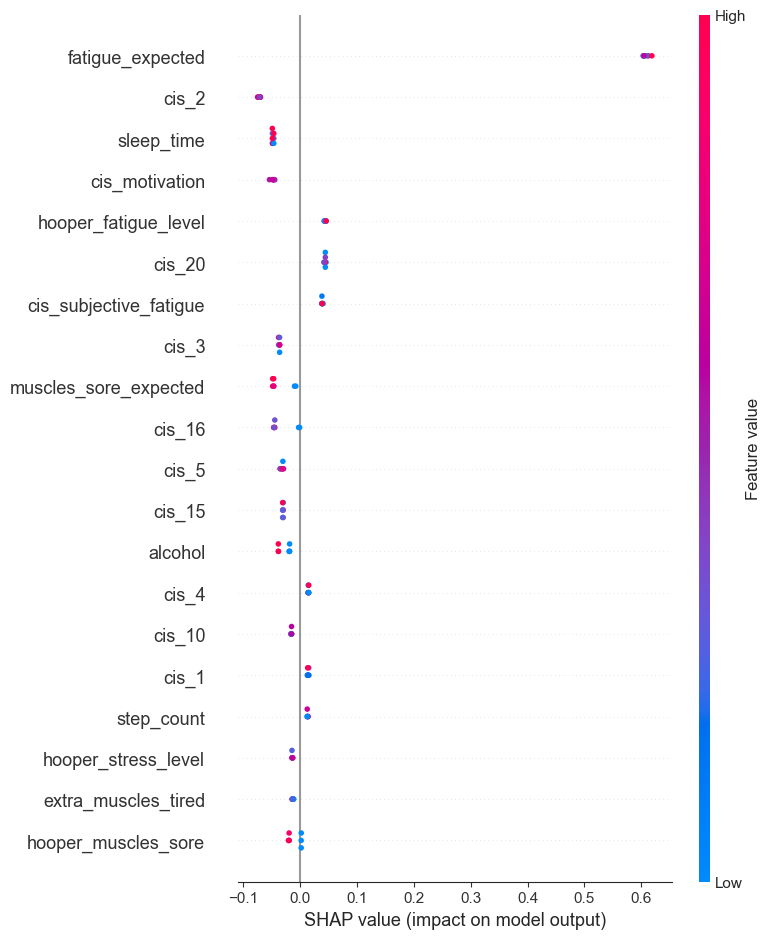

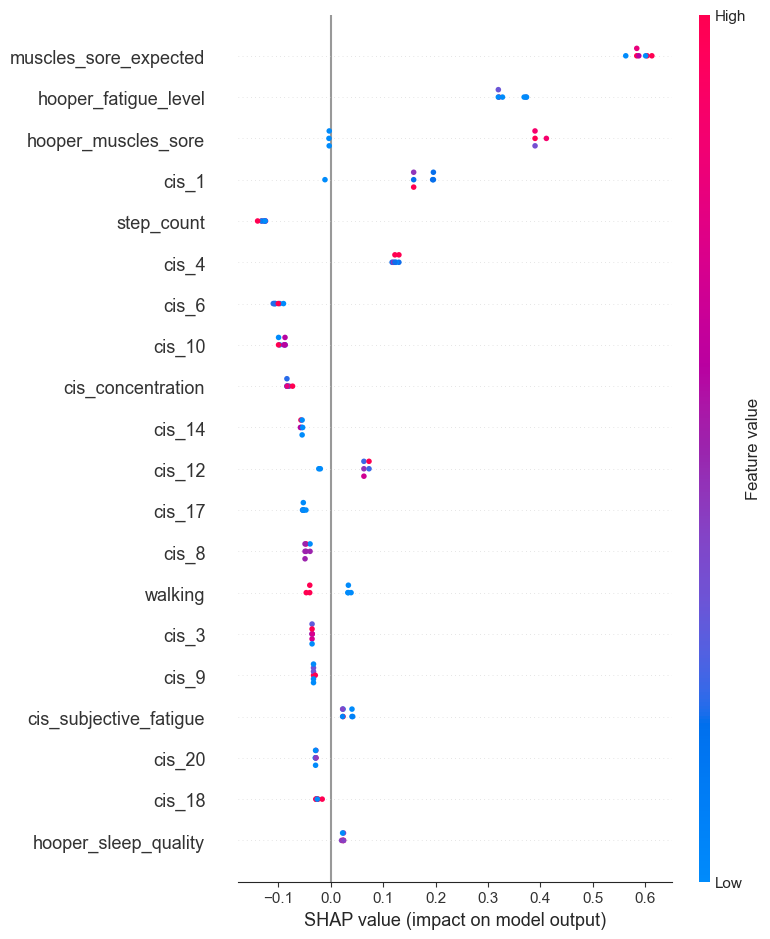

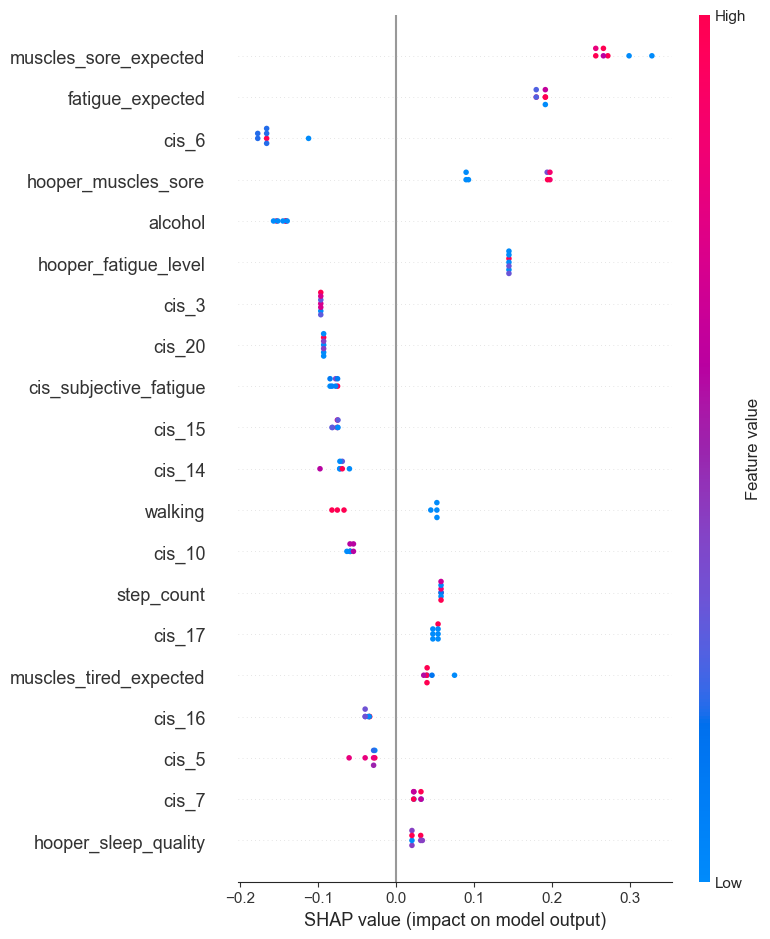

In [57]:
prediction_rf = pd.DataFrame()
for outcome in pred_variables:     
    X, y = data.loc[:end_train,vars].shift(1).dropna(), data.loc[data.loc[:end_train,vars].shift(1).dropna().index][outcome]


    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=40))
    ])

    # Fit the model
    pipeline.fit(X, y)

    # Predict on the test set
    y_pred = pipeline.predict(data.loc[end_train:,vars].shift(1).dropna())

    prediction_rf = pd.concat([prediction_rf,pd.DataFrame(y_pred).rename(columns={0:outcome})],axis=1)
    # Create a SHAP explainer
    explainer = shap.TreeExplainer(pipeline['regressor'])

    # Compute SHAP values for the test set
    shap_values = explainer.shap_values(data.loc[end_train:,vars].shift(1).dropna())
    shap.summary_plot(shap_values, data.loc[end_train:,vars].shift(1).dropna())
prediction_rf['model'] ='Random Forest'
prediction_rf.index =data.loc[end_train:,vars].shift(1).dropna().index


## RF - Time Series Forecaster
Adapted from https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn

In [423]:
from sklearn.ensemble import RandomForestRegressor

items = []
rf_mae_values = []
rf_predictions = {}
# Backtest forecaster
# ==============================================================================
forecaster_random_forest = ForecasterAutoreg(
                  regressor = RandomForestRegressor(random_state=123),
                  lags      = 5,
                  weight_func=custom_weights
             )
for i, item in enumerate(data_train.columns):
     print(item)
     rf_metric, rf_predictions_backtest = backtesting_forecaster(
                                        forecaster = forecaster_random_forest,
                                        y          = data[item],
                                        initial_train_size =len(data_train),
                                        fixed_train_size   = False,
                                        steps      = 1,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                   )
     items.append(item)
     rf_mae_values.append(rf_metric)
     rf_predictions[item] = rf_predictions_backtest

# Results
rf_uni_series_mae = pd.Series(
                     data  = rf_mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 );

cis_subjective_fatigue


The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/7 [00:00<?, ?it/s]

hooper_muscles_sore


The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/7 [00:00<?, ?it/s]

extra_muscles_tired


The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/7 [00:00<?, ?it/s]

## RF - Multiseries Forecaster

In [424]:
# Train and backtest a model for all items: ForecasterAutoregMultiSeries
# ======================================================================================
#items = list(data_all.columns)
items = pred_variables
# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = RandomForestRegressor(random_state=123),
                    lags               = 5,
                    encoding           = 'ordinal',
                    transformer_series = StandardScaler(),
                )
# Backtesting forecaster for all items
rf_multi_series_mae, rf_predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = data_all,
                                       levels             = items,
                                       steps              = 1,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(data_all.loc[:end_train]),
                                       refit              = True,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True 
                                    )
# Results
display(rf_multi_series_mae.head(3))
print('')
display(rf_predictions_ms.head(3))


The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/7 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,cis_subjective_fatigue,0.999865
1,hooper_muscles_sore,2.284060
2,extra_muscles_tired,1.768192


,cis_subjective_fatigue,hooper_muscles_sore,extra_muscles_tired
2024-07-22,3.382758,2.320991,3.645201
2024-07-23,2.094698,2.109018,2.413419
2024-07-24,3.717261,2.813192,3.555680


In [425]:
rf_multi_series_mae

,levels,mean_absolute_error
0,cis_subjective_fatigue,0.999865
1,hooper_muscles_sore,2.284060
2,extra_muscles_tired,1.768192


# Gradient Boosting
## GB - Standard / No Time Series

In [426]:
prediction_gb = pd.DataFrame()
for outcome in pred_variables:     
    X, y = data.loc[:end_train,vars].shift(1).dropna(), data.loc[data.loc[:end_train,vars].shift(1).dropna().index][outcome]



    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    # Train the model
    model.fit(X, y)

    # Make predictions
    # Predict on the test set
    y_pred = model.predict(data.loc[end_train:,vars].shift(1).dropna())

    prediction_gb = pd.concat([prediction_gb,pd.DataFrame(y_pred).rename(columns={0:outcome})],axis=1)
prediction_gb['model'] ='Gradient Boosting'
prediction_gb.index =data.loc[end_train:,vars].shift(1).dropna().index


## GB - Time Series Forecaster
Adapted from https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn

In [427]:
items = []
gb_mae_values = []
gb_predictions = {}
# Define forecaster
forecaster_gradient_boost = ForecasterAutoreg(
                    regressor     = HistGradientBoostingRegressor(random_state=8523),
                    lags          = 5,
                    transformer_y = StandardScaler()
                 )
for i, item in enumerate(tqdm(data_train.columns)):

     gb_metric, gb_predictions_backtest = backtesting_forecaster(
                                        forecaster = forecaster_gradient_boost,
                                        y          = data[item],
                                        initial_train_size = len(data.loc[:end_train]),
                                        fixed_train_size   = False,
                                        steps      = 1,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                   )

     items.append(item)
     gb_mae_values.append(gb_metric)
     gb_predictions[item] = gb_predictions_backtest

# Results
gb_uni_series_mae = pd.Series(
                     data  = gb_mae_values,
                     index = items,
                     name  = 'gb_uni_series_mae')

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/3 [00:00<?, ?it/s]

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/7 [00:00<?, ?it/s]

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/7 [00:00<?, ?it/s]

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/7 [00:00<?, ?it/s]

## GB- Multiseries Forecaset

In [428]:
# Train and backtest a model for all items: ForecasterAutoregMultiSeries
# ======================================================================================
items = list(data_all.columns)
items=pred_variables
# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=8523),
                    lags               = 5,
                    encoding           = 'ordinal',
                    transformer_series = StandardScaler(),
                )
# Backtesting forecaster for all items
gb_multi_series_mae, gb_predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = data_all,
                                       levels             = items,
                                       steps              = 1,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(data_all.loc[:end_train]),
                                       refit              = True,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True 
                                    )
# Results
display(gb_multi_series_mae.head(3))
print('')
display(gb_predictions_ms.head(3))


The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/7 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,cis_subjective_fatigue,1.072684
1,hooper_muscles_sore,2.700240
2,extra_muscles_tired,1.992757


,cis_subjective_fatigue,hooper_muscles_sore,extra_muscles_tired
2024-07-22,2.916183,3.450080,4.804222
2024-07-23,2.394111,2.734665,1.907373
2024-07-24,3.986925,1.651559,4.475180


# Lasso Regression

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


In [59]:
prediction_lasso = pd.DataFrame()
for outcome in pred_variables:     
    X, y = data.loc[:end_train,vars].shift(1).dropna(), data.loc[data.loc[:end_train,vars].shift(1).dropna().index][outcome]
    # define model
    model = Lasso(alpha=1.0)
    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['alpha'] = np.arange(0, 1, 0.01)
    # define search
    search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results = search.fit(X, y)


    model_opt_alpha = Lasso(alpha=results.best_params_['alpha'])
    model_opt_alpha.fit(X,y)
    prediction_lasso = pd.concat([prediction_lasso,pd.DataFrame(model_opt_alpha.predict(data.loc[end_train:,vars].shift(1).dropna())).rename(columns={0:outcome})],axis=1)
    print(outcome)
    print(pd.concat([pd.Series(model_opt_alpha.coef_),pd.Series(data.loc[:end_train,vars].shift(1).dropna().columns)],axis=1))

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit

cis_subjective_fatigue
           0                       1
0  -0.000000                   cis_1
1  -0.000000                   cis_2
2  -0.175061                   cis_3
3  -0.000000                   cis_4
4  -0.000000                   cis_5
5  -0.000000                   cis_6
6   0.094938                   cis_7
7  -0.000000                   cis_8
8  -0.000000                   cis_9
9  -0.000000                  cis_10
10 -0.000000                  cis_11
11 -0.000000                  cis_12
12 -0.000000                  cis_13
13 -0.243958                  cis_14
14 -0.035441                  cis_15
15 -0.000000                  cis_16
16  0.000000                  cis_17
17 -0.008296                  cis_18
18  0.000000                  cis_19
19  0.000000                  cis_20
20 -0.044599     hooper_muscles_sore
21 -0.000000     extra_muscles_tired
22 -0.173699    hooper_sleep_quality
23  0.000000    hooper_fatigue_level
24 -0.056892     hooper_stress_level
25 -0.000000   

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  re

hooper_muscles_sore
           0                       1
0   0.339471                   cis_1
1   0.064900                   cis_2
2  -0.160213                   cis_3
3   0.083076                   cis_4
4   0.004649                   cis_5
5  -0.738130                   cis_6
6   0.319937                   cis_7
7  -0.447874                   cis_8
8  -0.276690                   cis_9
9  -0.360036                  cis_10
10  0.438828                  cis_11
11  0.297364                  cis_12
12 -0.080586                  cis_13
13  0.189619                  cis_14
14  0.063618                  cis_15
15 -0.202464                  cis_16
16  0.008469                  cis_17
17 -0.181885                  cis_18
18 -0.046058                  cis_19
19 -0.101738                  cis_20
20  0.015153     hooper_muscles_sore
21  0.150106     extra_muscles_tired
22  0.047514    hooper_sleep_quality
23  0.104301    hooper_fatigue_level
24 -0.038060     hooper_stress_level
25  0.268956      

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and

extra_muscles_tired
           0                       1
0   0.000000                   cis_1
1   0.000000                   cis_2
2  -0.025909                   cis_3
3   0.000000                   cis_4
4  -0.000000                   cis_5
5  -1.260174                   cis_6
6   0.000000                   cis_7
7  -0.060116                   cis_8
8  -0.000000                   cis_9
9  -0.000000                  cis_10
10 -0.000000                  cis_11
11  0.000000                  cis_12
12 -0.000000                  cis_13
13 -0.000000                  cis_14
14 -0.760370                  cis_15
15 -0.054756                  cis_16
16 -0.193429                  cis_17
17 -0.000000                  cis_18
18  0.000000                  cis_19
19 -0.021417                  cis_20
20  0.000000     hooper_muscles_sore
21 -0.009004     extra_muscles_tired
22  0.000000    hooper_sleep_quality
23  0.000000    hooper_fatigue_level
24  0.000000     hooper_stress_level
25 -0.000000      

In [431]:
prediction_lasso['model'] = 'Lasso'
prediction_lasso.index =data.loc[end_train:,vars].shift(1).dropna().index
prediction_lasso

,cis_subjective_fatigue,hooper_muscles_sore,extra_muscles_tired,model
2024-07-22,3.397884,0.122905,4.299959,Lasso
2024-07-23,1.947126,2.458165,3.852589,Lasso
2024-07-24,3.876853,4.560154,4.647963,Lasso
2024-07-25,3.494093,4.940907,4.107356,Lasso
2024-07-26,1.306702,2.070707,-2.869431,Lasso
2024-07-27,3.243407,2.841183,4.049578,Lasso
2024-07-28,4.164527,1.962335,5.552081,Lasso


# Combine and Compare

In [432]:
def prep_pred_dataframe(preds, model):
    preds_df = pd.concat(preds.values(), axis=1)
    preds_df.columns = preds.keys()
    preds_df = preds_df.reset_index().melt(id_vars='index', var_name='measurement', value_name='value')
    preds_df['model'] = model
    return preds_df

In [433]:
gb_ms_df = gb_predictions_ms[pred_variables].reset_index().melt(id_vars='index', var_name='measurement', value_name='value')
gb_ms_df['model'] = 'Gradient Boosting Multiseries'

rf_ms_df = rf_predictions_ms[pred_variables].reset_index().melt(id_vars='index', var_name='measurement', value_name='value')
rf_ms_df['model'] = 'Random Forest Multiseries'

In [434]:
gb_df = prep_pred_dataframe(gb_predictions,'Gradient Boosting')
rf_df = prep_pred_dataframe(rf_predictions,'Random Forest')

In [435]:
# get Human prediction
human_df = human_prediction[['fatigue_prediction','muscles_tired_prediction','muscles_sore_prediction']][end_train:].\
rename(columns={'fatigue_prediction':'cis_subjective_fatigue','muscles_tired_prediction':'extra_muscles_tired','muscles_sore_prediction':'hooper_muscles_sore'}).\
reset_index().melt(id_vars='index', var_name='measurement', value_name='value')
human_df['model'] = 'Human Prediction'

In [436]:
# get mean
mean_df = df[pred_variables][:end_train].mean()
mean_df = mean_df.rename('mean')
mean_df = pd.merge(gb_ms_df[['index','measurement']],mean_df,how='left',right_index=True, left_on='measurement')
mean_df['model'] ="Always predict Mean"
mean_df = mean_df.rename(columns={'mean':'value'})


In [437]:
gb_ms_df_wide  = gb_ms_df.pivot(index='index',columns='measurement', values='value')
gb_ms_df_wide['model'] = 'Gradient boosting multiseries'

rf_ms_df_wide = rf_ms_df.pivot(index='index',columns='measurement', values='value')
rf_ms_df_wide['model'] = 'Random forest multiseries'

gb_df_wide = gb_df.pivot(index='index',columns='measurement', values='value')
gb_df_wide['model'] = 'Gradient boosting timeseries'

rf_df_wide = rf_df.pivot(index='index',columns='measurement', values='value')
rf_df_wide['model'] = 'Random forest time series'

human_df_wide = human_df.pivot(index='index',columns='measurement', values='value')
human_df_wide['model'] = 'Human Prediction'

mean_df_wide = mean_df.pivot(index='index',columns='measurement', values='value')
mean_df_wide['model'] = 'Always predicting the mean'


In [438]:
df_true = data_test[pred_variables]
df_true['model'] = 'Ground Truth'

In [439]:
if person =='Amanda':
    df_true = df_true.drop('2024-08-07')
    human_df_wide = human_df_wide.drop('2024-08-07')
if person =='Johanna':
    df_true = df_true.drop('2024-07-21')
    human_df_wide = human_df_wide.drop('2024-07-21')
#df_true

In [440]:
all_predictions = pd.concat([gb_ms_df_wide, rf_ms_df_wide,rf_df_wide, gb_df_wide, human_df_wide, mean_df_wide,df_true,prediction_lasso, prediction_rf,prediction_gb])
all_predictions['index'] = all_predictions.index
all_predictions

,cis_subjective_fatigue,extra_muscles_tired,hooper_muscles_sore,model,index
2024-07-22,2.916183,4.804222,3.450080,Gradient boosting multiseries,2024-07-22
2024-07-23,2.394111,1.907373,2.734665,Gradient boosting multiseries,2024-07-23
2024-07-24,3.986925,4.475180,1.651559,Gradient boosting multiseries,2024-07-24
2024-07-25,2.799626,1.444737,4.675842,Gradient boosting multiseries,2024-07-25
2024-07-26,3.786342,3.489365,3.545411,Gradient boosting multiseries,2024-07-26
...,...,...,...,...,...
2024-07-24,3.505221,4.837982,3.001273,Gradient Boosting,2024-07-24
2024-07-25,2.927718,4.335040,5.334459,Gradient Boosting,2024-07-25
2024-07-26,3.440055,3.451629,3.627543,Gradient Boosting,2024-07-26
2024-07-27,3.884521,4.837692,2.394590,Gradient Boosting,2024-07-27


In [444]:
all_predictions.index.unique()

DatetimeIndex(['2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-27', '2024-07-28'],
              dtype='datetime64[ns]', freq=None)

In [445]:
all_predictions[['cis_subjective_fatigue',	'extra_muscles_tired',	'hooper_muscles_sore']] = all_predictions[['cis_subjective_fatigue',	'extra_muscles_tired',	'hooper_muscles_sore']].applymap(lambda x: 1 if x < 1 else x)
all_predictions[['cis_subjective_fatigue',	'extra_muscles_tired',	'hooper_muscles_sore']] = all_predictions[['cis_subjective_fatigue',	'extra_muscles_tired',	'hooper_muscles_sore']].applymap(lambda x: 7 if x >7 else x)


In [446]:
all_predictions['person'] =person
#all_predictions = all_predictions[all_predictions['index']>pd.to_datetime('2024-07-22')]

In [447]:
all_predictions.to_csv('/Users/htr365/no_icloud/quantified_self_all/quantified_self/website/docs/data/predictions_'+person+'.csv')

In [448]:
all_predictions_amanda = pd.read_csv(('/Users/htr365/no_icloud/quantified_self_all/quantified_self/website/docs/data/predictions_Amanda.csv'))
all_predictions_johanna= pd.read_csv(('/Users/htr365/no_icloud/quantified_self_all/quantified_self/website/docs/data/predictions_Johanna.csv'))

In [449]:
pd.concat([all_predictions_johanna,all_predictions_amanda])

,Unnamed: 0,cis_subjective_fatigue,extra_muscles_tired,hooper_muscles_sore,model,index,person
0,2024-07-22,2.916183,4.804222,3.450080,Gradient boosting multiseries,2024-07-22,Johanna
1,2024-07-23,2.394111,1.907373,2.734665,Gradient boosting multiseries,2024-07-23,Johanna
2,2024-07-24,3.986925,4.475180,1.651559,Gradient boosting multiseries,2024-07-24,Johanna
3,2024-07-25,2.799626,1.444737,4.675842,Gradient boosting multiseries,2024-07-25,Johanna
4,2024-07-26,3.786342,3.489365,3.545411,Gradient boosting multiseries,2024-07-26,Johanna
...,...,...,...,...,...,...,...
65,2024-08-10,2.445082,2.626476,2.295289,Gradient Boosting,2024-08-10,Amanda
66,2024-08-11,3.251650,3.163093,4.138082,Gradient Boosting,2024-08-11,Amanda
67,2024-08-12,3.687401,4.354936,4.320752,Gradient Boosting,2024-08-12,Amanda
68,2024-08-13,2.275682,1.866278,2.232001,Gradient Boosting,2024-08-13,Amanda


In [450]:
pd.concat([all_predictions_johanna,all_predictions_amanda]).to_csv('/Users/htr365/no_icloud/quantified_self_all/quantified_self/website/docs/data/predictions.csv')

# OLD STUFF

In [76]:

def pred_to_df(predictions):
    combined_df= pd.DataFrame()

    # Loop through each key, value pair in the dictionary
    for key, df in predictions.items():
        # Rename the 'pred' column to the key value
        df = df.rename(columns={'pred': key})
        # Concatenate along columns
        if combined_df.empty:
            combined_df = df
        else:
            combined_df = pd.concat([combined_df, df], axis=1)
    return combined_df

In [77]:
rf_test_pred = pred_to_df(rf_predictions)
gb_test_pred = pred_to_df(gb_predictions)

In [78]:
var_outcome = 'cis_subjective_fatigue'#,'hooper_fatigue_level','extra_muscles_tired','hooper_muscles_sore']
human_pred = ['fatigue_expected','muscles_sore_expected','muscles_tired_expected']

In [79]:
dict_human = {'cis_subjective_fatigue':'fatigue_expected',
              'hooper_fatigue_level':'fatigue_expected',
              'extra_muscles_tired':'muscles_tired_expected',
              'hooper_muscles_sore':'muscles_sore_expected'}

In [80]:
dict_human.get(var_outcome)

'fatigue_expected'

In [97]:
data_test.index

DatetimeIndex(['2024-07-27', '2024-07-28', '2024-07-29'], dtype='datetime64[ns]', name='date', freq='D')

In [124]:
import datetime
data_human_pred = data[np.isin(data.index,data_test.index-datetime.timedelta(days=1))][dict_human.get(var_outcome)].rename('h_'+var_outcome)
data_human_pred.index = data_human_pred.index +datetime.timedelta(days=1)

In [125]:
results = pd.concat([rf_test_pred[var_outcome].rename('rf_'+var_outcome),
gb_test_pred[var_outcome].rename('gb_'+var_outcome),
data_human_pred],
axis=1)

results_diff = data_test[var_outcome]-results
results

,rf_cis_subjective_fatigue,gb_cis_subjective_fatigue,h_cis_subjective_fatigue
2024-07-26,4.917500,4.831731,NaN
2024-07-27,4.522500,4.831731,4.0
2024-07-28,4.845625,4.831731,7.0
2024-07-29,4.905625,4.831731,7.0


In [86]:
data_test.columns

Index(['person', 'date', 'cis_1', 'cis_2', 'cis_3', 'cis_4', 'cis_5', 'cis_6',
       'cis_7', 'cis_8', 'cis_9', 'cis_10', 'cis_11', 'cis_12', 'cis_13',
       'cis_14', 'cis_15', 'cis_16', 'cis_17', 'cis_18', 'cis_19', 'cis_20',
       'hooper_muscles_sore', 'extra_muscles_tired', 'hooper_sleep_quality',
       'hooper_fatigue_level', 'hooper_stress_level', 'sleep_hours',
       'coffee_count', 'physical_activity', 'step_count', 'alcohol',
       'fatigue_expected', 'muscles_sore_expected', 'muscles_tired_expected',
       'cis_subjective_fatigue', 'cis_concentration', 'cis_motivation',
       'cis_physical_activity', 'sleep_time', 'walking', 'cycling',
       'ball_sports', 'weight_lifting', 'running', 'yoga', 'HITT',
       'manual_labour', 'hiking', 'cis_subjective_fatigue_lead1',
       'hooper_fatigue_level_lead1'],
      dtype='object')

In [126]:
np.abs(data_test[var_outcome] - results.transpose()).transpose()

,rf_cis_subjective_fatigue,gb_cis_subjective_fatigue,h_cis_subjective_fatigue
2024-07-26,NaN,NaN,NaN
2024-07-27,2.522500,2.831731,2.000
2024-07-28,0.029375,0.043269,2.125
2024-07-29,1.094375,1.168269,1.000
